In [66]:
import pandas as pd
import numpy as np

# ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier

import joblib
import re


In [67]:
# โหลดข้อมูล
df = pd.read_csv("15.job_description_synthetic.csv")

df.head()


,job_family,seniority,contract_type,region_code,remote_flag,min_years_exp,edu_min,responsibilities_count,requirements_count,tools_mentioned,...,sales_skill,marketing_skill,ops_skill,salary_min,salary_max,salary_per_year_exp,req_to_resp_ratio,skill_density,complexity,jd_text
0,4,3,0,5,0,9.98,1,11,11,6,...,47.1,72.7,49.4,84557,109427,8832.79,1.000,13.410,0.441,"Senior Marketing role. Focus on SEO, ads, and ..."
1,3,1,0,3,0,1.54,1,9,10,7,...,100.0,45.8,54.4,34284,56779,17900.13,1.111,16.496,2.281,"Junior Sales role. Focus on CRM, pipeline, and..."
2,4,1,0,4,1,5.24,3,6,15,6,...,56.0,64.6,39.3,52734,76969,10387.84,2.500,13.884,1.584,"Junior Marketing role. Focus on SEO, analytics..."
3,5,4,0,5,1,10.88,2,17,14,6,...,44.0,57.6,91.3,100107,149214,10491.63,0.824,11.020,1.745,"Lead Operations role. Focus on coordination, l..."
4,0,3,0,3,0,6.82,1,12,18,8,...,23.9,51.6,49.3,38648,127629,10631.81,1.500,8.871,2.113,"Senior Software role. Focus on API, CI/CD, and..."


In [68]:
# ดูข้อมูลคร่าว ๆ
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   job_family              4000 non-null   int64  
 1   seniority               4000 non-null   int64  
 2   contract_type           4000 non-null   int64  
 3   region_code             4000 non-null   int64  
 4   remote_flag             4000 non-null   int64  
 5   min_years_exp           4000 non-null   float64
 6   edu_min                 4000 non-null   int64  
 7   responsibilities_count  4000 non-null   int64  
 8   requirements_count      4000 non-null   int64  
 9   tools_mentioned         4000 non-null   int64  
 10  lang_req                4000 non-null   int64  
 11  tech_skill              4000 non-null   float64
 12  data_skill              4000 non-null   float64
 13  design_skill            4000 non-null   float64
 14  sales_skill             4000 non-null   

In [69]:
# ลบแถวที่ target หาย
df = df.dropna(subset=["job_family"])

# เติมค่า missing เชิงตัวเลข
num_cols = df.select_dtypes(include=["int64", "float64"]).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# เติมค่า missing เชิงข้อความ
df["jd_text"] = df["jd_text"].fillna("")


In [70]:
def thai_tokenizer(text):
    text = str(text).lower()
    tokens = re.findall(r"[A-Za-z]+|[ก-๙]+|\d+", text)
    return tokens


In [71]:
# salary_per_year_exp
df["salary_per_year_exp"] = (
    (df["salary_min"] + df["salary_max"]) / 2
) / (df["min_years_exp"] + 1)

# req_to_resp_ratio
df["req_to_resp_ratio"] = (
    df["requirements_count"] / df["responsibilities_count"]
)

# skill_density
skill_cols = [
    "tech_skill", "data_skill", "design_skill",
    "sales_skill", "marketing_skill", "ops_skill"
]

df["skill_density"] = (
    df[skill_cols].sum(axis=1)
    / (df["requirements_count"] + df["responsibilities_count"])
)

# complexity
df["complexity"] = (
    df["seniority"] * 10
    + df["tools_mentioned"] * 2
    + df["requirements_count"]
    + df["responsibilities_count"]
)


In [72]:
TARGET = "job_family"

TEXT_FEATURE = "jd_text"

NUM_FEATURES = [
    "min_years_exp",
    "responsibilities_count",
    "requirements_count",
    "tools_mentioned",
    "salary_min",
    "salary_max",
    "salary_per_year_exp",
    "req_to_resp_ratio",
    "skill_density",
    "complexity",
    "tech_skill",
    "data_skill",
    "design_skill",
    "sales_skill",
    "marketing_skill",
    "ops_skill",
]

CAT_FEATURES = [
    "seniority",
    "contract_type",
    "region_code",
    "remote_flag",
    "edu_min",
    "lang_req",
]

X = df[NUM_FEATURES + CAT_FEATURES + [TEXT_FEATURE]]
y = df[TARGET]


In [73]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [74]:
numeric_transformer = Pipeline([
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

text_transformer = TfidfVectorizer(
    tokenizer=thai_tokenizer,
    max_features=3000,
    ngram_range=(1, 2)
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, NUM_FEATURES),
        ("cat", categorical_transformer, CAT_FEATURES),
        ("txt", text_transformer, TEXT_FEATURE),
    ]
)


In [75]:
logistic_model = Pipeline([
    ("preprocess", preprocessor),
    ("clf", LogisticRegression(
        max_iter=1000,
        multi_class="multinomial",
        n_jobs=-1
    ))
])

logistic_model.fit(X_train, y_train)

y_pred = logistic_model.predict(X_test)
print("Logistic Regression")
print(classification_report(y_test, y_pred))


c:\Users\nine0\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\nine0\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       142
           1       0.99      0.98      0.99       125
           2       0.99      0.99      0.99       130
           3       0.99      1.00      1.00       133
           4       1.00      1.00      1.00       138
           5       1.00      0.99      1.00       132

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       1.00      0.99      0.99       800



In [76]:
joblib.dump(logistic_model, "Logistic.joblib")


['Logistic.joblib']

In [77]:
svm_base = LinearSVC()

svm_model = Pipeline([
    ("preprocess", preprocessor),
    ("clf", CalibratedClassifierCV(
        svm_base,
        method="sigmoid"
    ))
])

svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)
print("SVM")
print(classification_report(y_test, y_pred))
joblib.dump(svm_model, "SVM.joblib")



c:\Users\nine0\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


SVM
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       142
           1       1.00      1.00      1.00       125
           2       1.00      1.00      1.00       130
           3       1.00      1.00      1.00       133
           4       1.00      1.00      1.00       138
           5       1.00      1.00      1.00       132

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



['SVM.joblib']

In [78]:
rf_model = Pipeline([
    ("preprocess", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    ))
])

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
print("Random Forest")
print(classification_report(y_test, y_pred))
joblib.dump(rf_model, "RandomForest.joblib")


c:\Users\nine0\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       142
           1       1.00      1.00      1.00       125
           2       1.00      1.00      1.00       130
           3       1.00      1.00      1.00       133
           4       1.00      1.00      1.00       138
           5       1.00      1.00      1.00       132

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



['RandomForest.joblib']

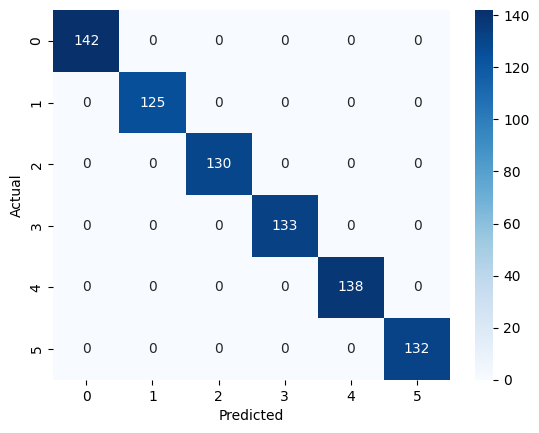

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
